数据来源：#kaggle地址：https://www.kaggle.com/c/bike-sharing-demand

数据预处理

##pdpbox这个库要求matplotlib的版本必须是2.1.2，所以需要强制安装，实测并不影响代码运行

##pip install --upgrade --force-reinstall --no-deps pdpbox==0.2.1

In [1]:
##导入相关包
import numpy as np
import pandas as pd 
import calendar
from datetime import datetime
from scipy import stats
from scipy.stats import norm

##数据可视化
import matplotlib.pyplot as plt
import seaborn as sns 

##机器学习模型
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt

##设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']##设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False##解决负号显示问题

认识数据

In [2]:
data = pd.read_csv("./data/data.csv", parse_dates=True)##parse_dates=True将csv中的时间字符串转换成日期格式
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-1-1 0:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-1-1 1:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-1-1 2:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-1-1 3:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-1-1 4:00,1,0,0,1,9.84,14.395,75,0.0,1


In [3]:
data.shape

(10886, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


特征工程

对日期数据进行处理，提取时间相关信息

In [5]:
format = '%Y-%m-%d %H:%M'##调整格式字符串
data['date'] = pd.to_datetime(data['datetime'], format=format)
data['month'] = data.date.dt.month
data['day'] = data.date.dt.day
data['weekday'] = data.date.dt.weekday
data['hour'] = data.date.dt.hour

data.drop(['date'], axis=1, inplace=True)##删除不需要的列
data.drop(['datetime'], axis=1, inplace=True)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   month       10886 non-null  int32  
 10  day         10886 non-null  int32  
 11  weekday     10886 non-null  int32  
 12  hour        10886 non-null  int32  
dtypes: float64(3), int32(4), int64(6)
memory usage: 935.6 KB


描述性统计

观察每个离散性特征对于标签的影响

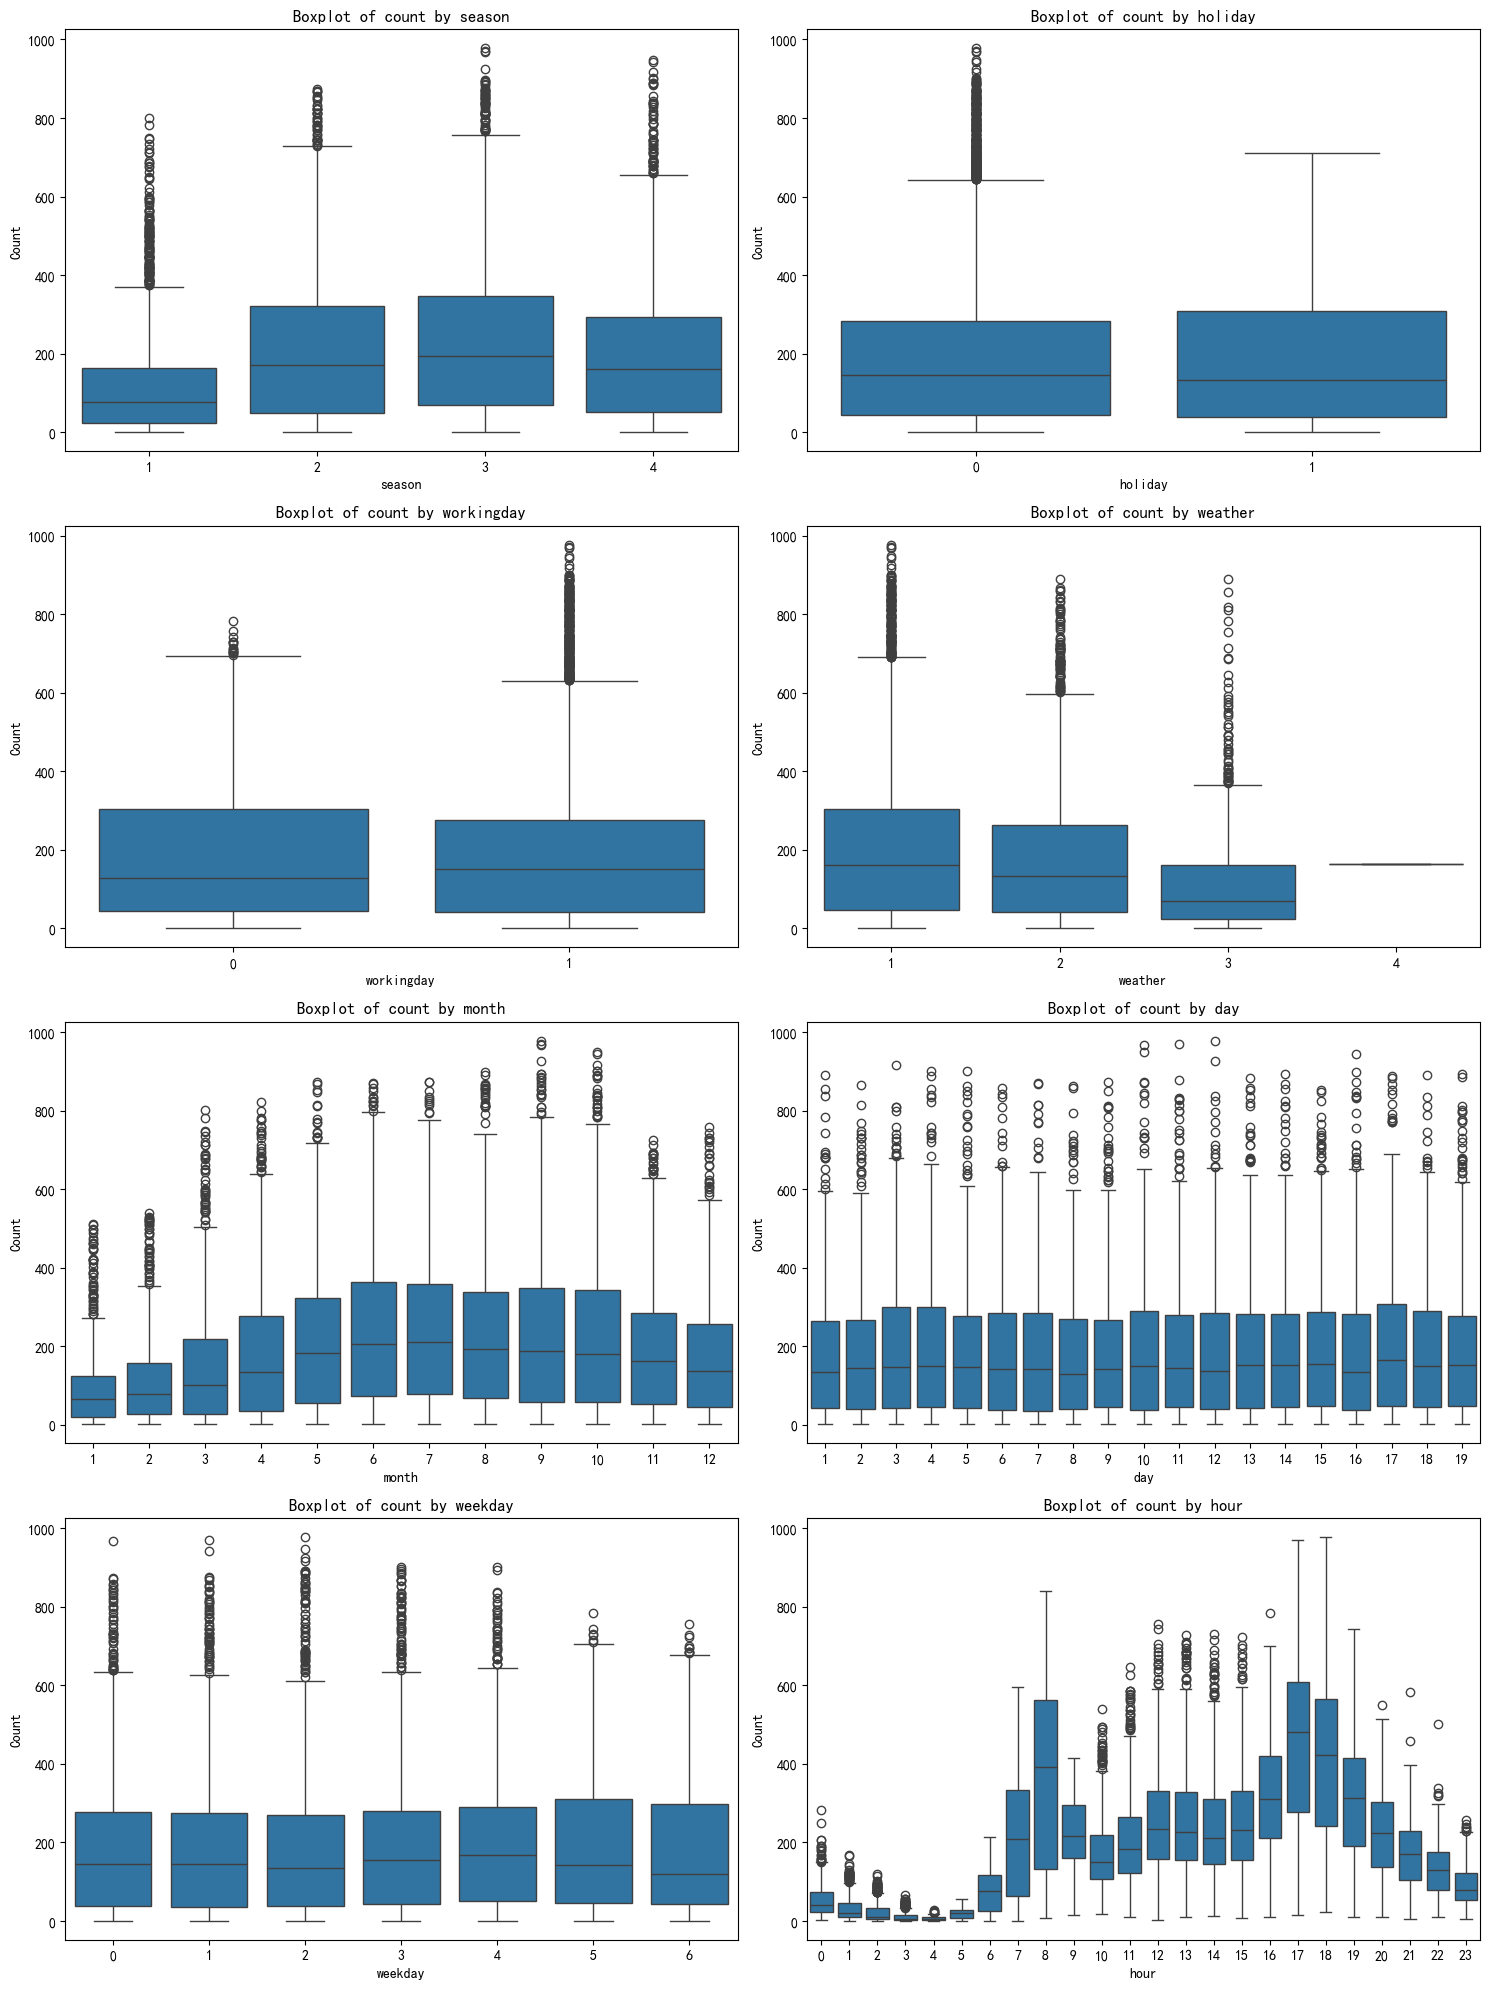

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
discrete_vars = ['season', 'holiday', 'workingday', 'weather', 'month', 'day', 'weekday', 'hour']# 定义离散变量列表

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))##创建子图布局
axes = axes.flatten()

for i, var in enumerate(discrete_vars):##遍历离散变量并绘制箱线图
    sns.boxplot(data=data, x=var, y='count', ax=axes[i])
    axes[i].set_title(f'Boxplot of count by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

plt.tight_layout()##调整子图布局
plt.show()

观察连续特征对于标签的影响

<Axes: >

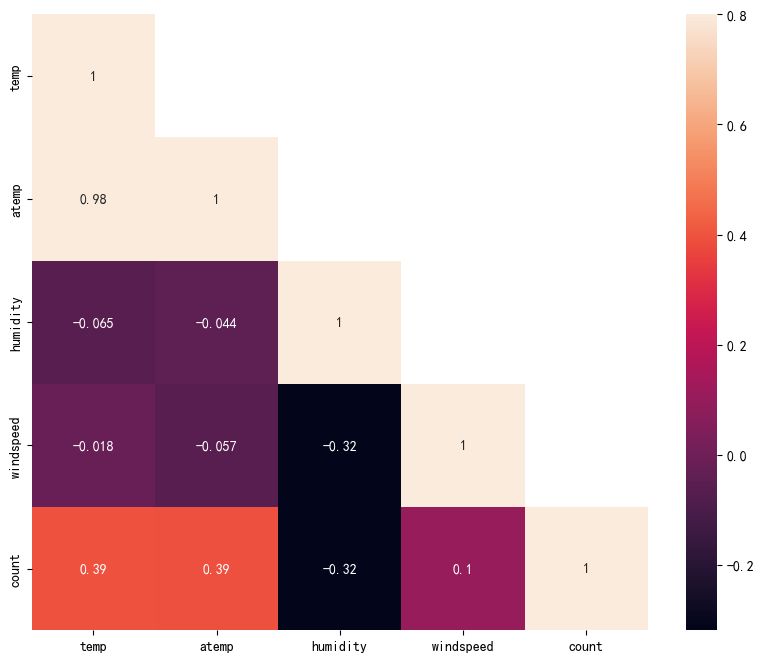

In [7]:
corr_df = data[["temp", "atemp", "humidity", "windspeed", "count"]].corr()##绘制原始数据的热力图，查看特征之间的相关性
mask = np.array(corr_df)
mask[np.tril_indices_from(mask)] = False  # mask = np.zeros_like(corr) # mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, mask=mask, vmax=0.8, square=True, annot=True)

In [8]:
##temp和atemp之间有很强的相关性，同时纳入模型的话会造成多重共线性问题
##选择删除atemp特征，因为它与count之间的相关性比temp弱
data=data.drop(['atemp'],axis=1)
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,month,day,weekday,hour
0,1,0,0,1,9.84,81,0.0,16,1,1,5,0
1,1,0,0,1,9.02,80,0.0,40,1,1,5,1
2,1,0,0,1,9.02,80,0.0,32,1,1,5,2
3,1,0,0,1,9.84,75,0.0,13,1,1,5,3
4,1,0,0,1,9.84,75,0.0,1,1,1,5,4


划分数据

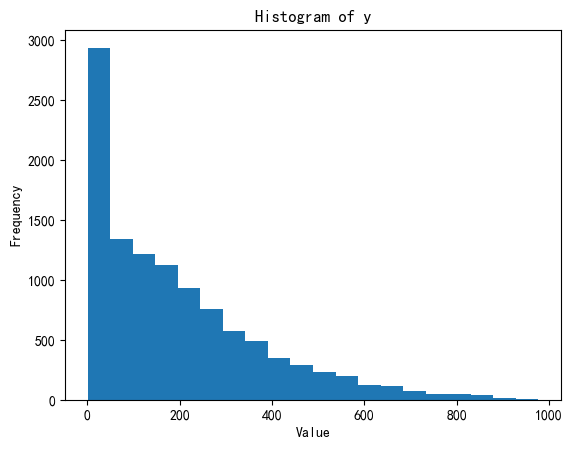

In [9]:
##分离特征数据和标签数据
X = data.drop(['count'], axis=1)##特征数据
y = data['count']##标签数据

import matplotlib.pyplot as plt

plt.hist(y, bins=20)##绘制直方图，bins参数可以调整直方图的柱子数量

plt.title('Histogram of y')##添加标题和坐标轴标签
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()##显示图形

In [10]:
##使用train_test_split函数按照8:2的比例划分数据集，test_size=0.2表示将20%的数据用作测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8708, 11) (2178, 11) (8708,) (2178,)


异常值处理

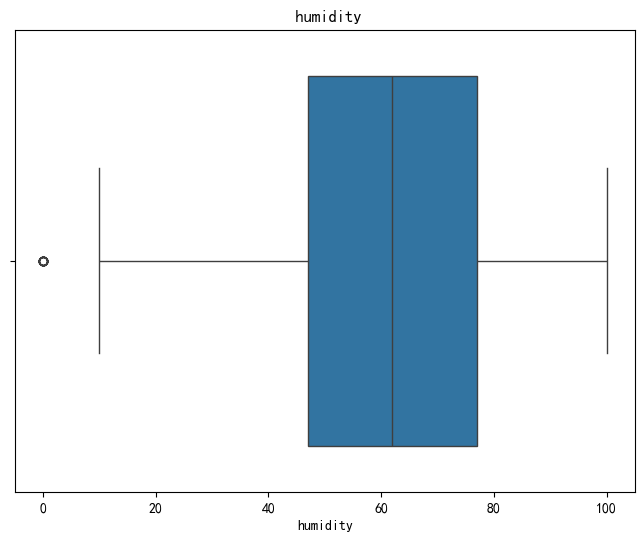

In [11]:
##利用箱线图可视化连续特征—湿度
plt.figure(figsize=(8, 6))
sns.boxplot(x=X_train['humidity'])
plt.title(" humidity")
plt.show()

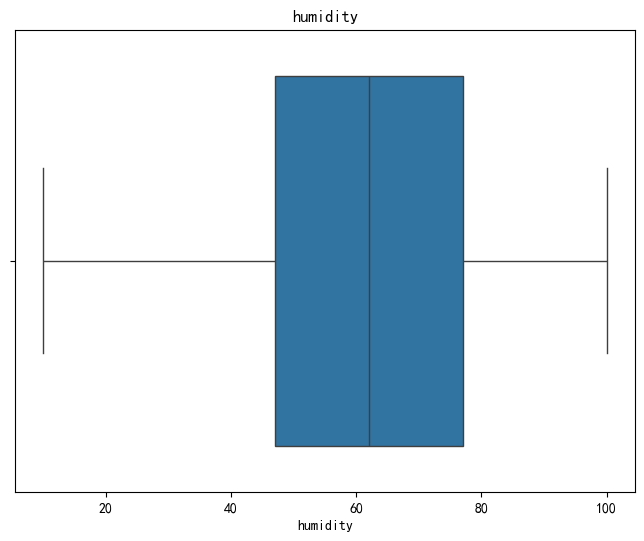

In [12]:
Q1 = X_train['humidity'].quantile(0.25)##计算Q1，Q3和IQR
Q3 = X_train['humidity'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR##定义异常值的上下界
upper_bound = Q3 + 1.5 * IQR

mask = (X_train['humidity'] >= lower_bound) & (X_train['humidity'] <= upper_bound)##删除异常值
X_train = X_train[mask]##删除X_train中的异常值样本
y_train = y_train[mask]##同步删除y_train中对应的样本

plt.figure(figsize=(8, 6))##绘制的是删除异常值后的数据的图
sns.boxplot(x=X_train['humidity'])
plt.title("humidity")
plt.show()

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8690 entries, 2815 to 7270
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8690 non-null   int64  
 1   holiday     8690 non-null   int64  
 2   workingday  8690 non-null   int64  
 3   weather     8690 non-null   int64  
 4   temp        8690 non-null   float64
 5   humidity    8690 non-null   int64  
 6   windspeed   8690 non-null   float64
 7   month       8690 non-null   int32  
 8   day         8690 non-null   int32  
 9   weekday     8690 non-null   int32  
 10  hour        8690 non-null   int32  
dtypes: float64(2), int32(4), int64(5)
memory usage: 678.9 KB


本回归任务采用线性回归方法

机器学习建模

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()##初始化模型

linear_model.fit(X_train, y_train)##训练模型

y_test_pred = linear_model.predict(X_test)##预测

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)##计算RMSE

print(f"线性回归模型测试集 RMSE: {test_rmse:.4f}")##输出结果

线性回归模型测试集 RMSE: 147.1889


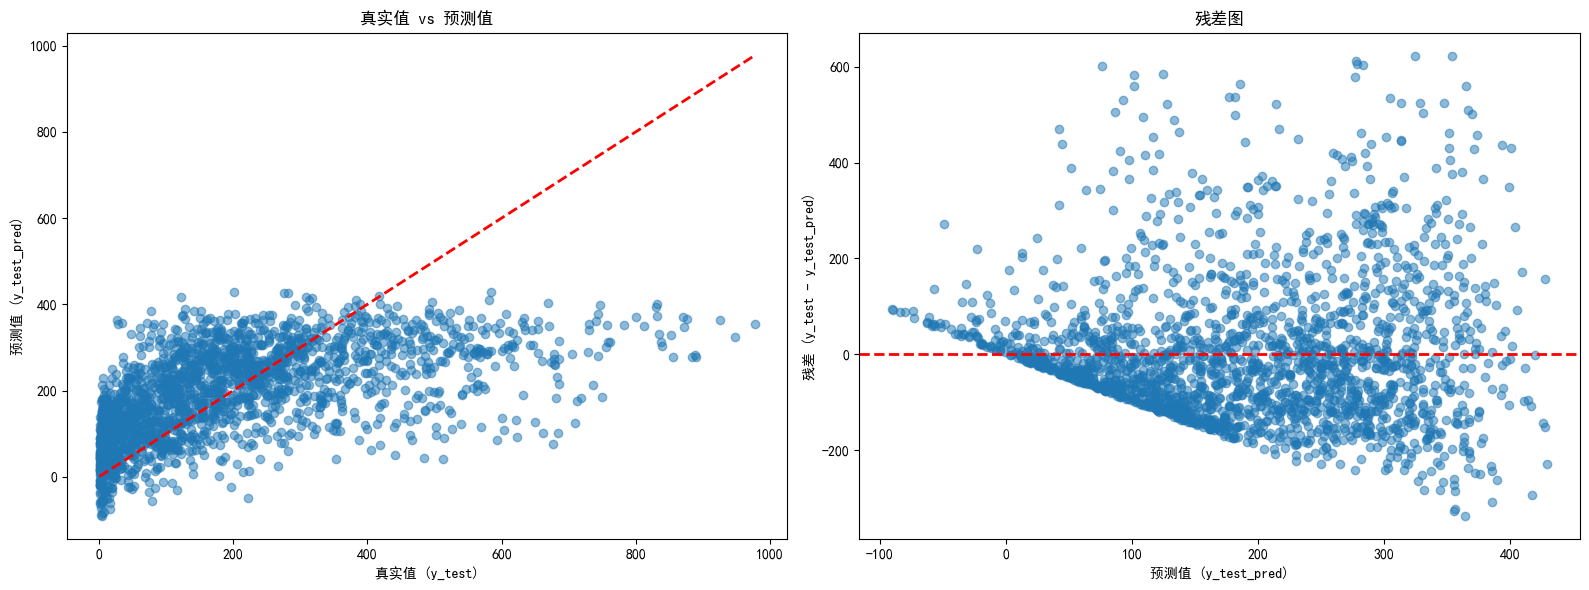

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']##设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False##解决负号显示问题

fig, axes = plt.subplots(1, 2, figsize=(16, 6))##创建图形

axes[0].scatter(y_test, y_test_pred, alpha=0.5)##1.真实值vs预测值
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)##绘制y = x的参考线
axes[0].set_xlabel("真实值 (y_test)")
axes[0].set_ylabel("预测值 (y_test_pred)")
axes[0].set_title("真实值 vs 预测值")

residuals = y_test - y_test_pred##2. 残差图
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)##绘制y = 0的参考线
axes[1].set_xlabel("预测值 (y_test_pred)")
axes[1].set_ylabel("残差 (y_test - y_test_pred)")
axes[1].set_title("残差图")

plt.tight_layout()##显示图形
plt.show()


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


决策树

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dt_model = DecisionTreeRegressor(random_state=42)##初始化决策树回归模型（使用默认参数）

dt_model.fit(X_train, y_train)##训练模型

y_test_pred = dt_model.predict(X_test)##预测

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)##计算RMSE

print(f"决策树默认参数模型测试集 RMSE: {test_rmse:.4f}")##输出结果

决策树默认参数模型测试集 RMSE: 90.0495


随机森林

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)##初始化随机森林回归模型
##n_estimators是树的数量

rf_model.fit(X_train, y_train)##训练模型

y_test_pred = rf_model.predict(X_test)##预测

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)##计算RMSE

print(f"随机森林回归模型测试集 RMSE: {test_rmse:.4f}")##输出结果

随机森林回归模型测试集 RMSE: 65.8694


In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import numpy as np

# ... （保留原有的数据预处理等必要导入）

# ============= 超参优化部分 ==============
# 定义更广范围的参数分布字典
param_dist = {
    "n_estimators": stats.randint(50, 250),        # 覆盖原有两个范围的树数量
    "max_depth": [None] + list(range(5, 31)),      # 包含原有两个范围的深度设定
    "min_samples_split": stats.randint(2, 11),     # 覆盖原有两个分裂样本需求范围
    "min_samples_leaf": stats.randint(1, 5),       # 覆盖原有两个叶节点样本需求范围
    "max_features": ['sqrt', 'log2'] + list(np.linspace(0.05, 1., num=20))
}

rf_model = RandomForestRegressor(random_state=42)

# 初始化并执行随机搜索
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,
 cv=5,
 scoring='neg_mean_squared_error',
 random_state=42,
 n_jobs=-1 
)

random_search.fit(X_train,y_train)

print(f"最优超参组合: {random_search.best_params_}")

# ============= 模型评估部分 ==============
best_rf_model = random_search.best_estimator_
y_test_pred = best_rf_model.predict(X_test)
test_rmse = mean_squared_error(y_test,y_test_pred,squared=False)
print(f"\n优化后测试集 RMSE: {test_rmse:.4f}")

最优超参组合: {'max_depth': 24, 'max_features': 0.5499999999999999, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 138}

优化后测试集 RMSE: 61.6491


XGBoost

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_model = XGBRegressor(random_state=42)##初始化XGBoost回归模型（使用默认参数）

xgb_model.fit(X_train, y_train)##训练模型

y_test_pred = xgb_model.predict(X_test)##预测

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)##计算RMSE

print(f"XGBoost 默认参数模型测试集 RMSE: {test_rmse:.4f}")##输出结果

print("XGBoost 默认参数：")##打印默认参数
print(xgb_model.get_params())

XGBoost 默认参数模型测试集 RMSE: 57.5217
XGBoost 默认参数：
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats

# ============= 优化后的参数分布设置 ==============
param_dist = {
    'n_estimators': stats.randint(50, 200),        # 更宽泛的树数量范围
    'max_depth': stats.randint(3, 12),             # 扩展最大深度范围
    'learning_rate': stats.loguniform(1e-3, 0.5),  # 对数均匀分布覆盖更合理的学习率范围
    'subsample': stats.uniform(0.5, 0.5),          # 生成0.5-1.0之间的连续值
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_alpha': stats.expon(scale=0.1),           # 指数分布适合正则项系数
    'reg_lambda': stats.expon(scale=0.1)
}

xgb_model = XGBRegressor(random_state=42)

# ============= 初始化并执行随机搜索 ==============
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,              # 只需定义采样次数而非全组合
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1                # 使用全部CPU核心加速
)

random_search.fit(X_train, y_train)

# ============= 结果输出部分 ==============
print(f"最优参数: {random_search.best_params_}")

best_xgb_model = random_search.best_estimator_
y_test_pred = best_xgb_model.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"优化后 XGBoost 模型测试集 RMSE: {test_rmse:.4f}")


最优参数: {'colsample_bytree': 0.770723986913783, 'learning_rate': 0.07549205077215225, 'max_depth': 9, 'n_estimators': 193, 'reg_alpha': 0.16994840726392213, 'reg_lambda': 0.08101323606865081, 'subsample': 0.7648252891780032}
优化后 XGBoost 模型测试集 RMSE: 54.2655


lightGBM

In [21]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

lgbm_model = LGBMRegressor(random_state=42)##初始化LightGBM回归模型（使用默认参数）

lgbm_model.fit(X_train, y_train)##训练模型

y_test_pred = lgbm_model.predict(X_test)##预测

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)##计算#RMSE

print(f"LightGBM 默认参数模型测试集 RMSE: {test_rmse:.4f}")##输出结果

print("LightGBM 默认参数：")##打印默认参数
print(lgbm_model.get_params())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 11
[LightGBM] [Info] Start training from score 191.929574
LightGBM 默认参数模型测试集 RMSE: 60.3508
LightGBM 默认参数：
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [22]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# ============= 优化版随机搜索 ==============
lgbm_model = LGBMRegressor(random_state=42)

# 扩展为概率分布的超参空间
param_dist = {
    'num_leaves': stats.randint(20, 150),          # 更宽泛的叶子数范围
    'learning_rate': stats.loguniform(0.005, 0.2), # 对数均匀分布更合理
    'subsample': stats.uniform(0.6, 0.4),          # 生成0.6-1.0连续值
    'colsample_bytree': stats.uniform(0.6, 0.4),
    'n_estimators': stats.randint(50, 500),        # 新增重要参数
    'max_depth': [-1] + list(range(3,12)),         # -1表示无限制
    'reg_alpha': stats.expon(scale=1),             # L1正则系数
    'reg_lambda': stats.expon(scale=1)             # L2正则系数
}

random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=100,                   # 采样次数（原网格共3*3*2*2=36种组合）
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

# ============= 结果输出 ==============
print("最佳参数：", random_search.best_params_)

# 无需重新训练（RandomizedSearchCV默认refit=True会自动用全数据训练最佳模型）
y_test_pred = random_search.best_estimator_.predict(X_test)  

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"调参后模型测试集 RMSE: {test_rmse:.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 11
[LightGBM] [Info] Start training from score 191.929574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

stacking模型融合

In [23]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ================== 配置管理 ==================
def get_model_configs():
    """返回所有优化后的模型配置"""
    return {
        'rf': {
            'class': RandomForestRegressor,
            'params': {
                'max_depth': 24,
                'max_features': 0.55,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'n_estimators': 138,
                'random_state': 42,
                'n_jobs': -1
            }
        },
        'xgb': {
            'class': XGBRegressor,
            'params': {
                'colsample_bytree': 0.7707,
                'learning_rate': 0.0755,
                'max_depth': 9,
                'n_estimators': 193,
                'reg_alpha': 0.1699,
                'reg_lambda': 0.0810,
                'subsample': 0.7648,
                'random_state': 42,
                'n_jobs': -1
            }
        },
        'lgbm': {
            'class': LGBMRegressor,
            'params': {
                'colsample_bytree': 0.8071,
                'learning_rate': 0.1099,
                'max_depth': 10, 
                'n_estimators': 483,
                'num_leaves': 61, 
                'reg_alpha': 0.2983, 
                'reg_lambda': 1.0788, 
                'subsample': 0.9269,
                'random_state':42,
                'n_jobs': -1
            }
        }
    }

# ================== 实验设计 ==================
def generate_experiments():
    """生成不同元模型和基模型的组合方案"""
    return [
        {
            'name':'Full Ensemble + XGBoost Meta',
            'base_models': ['rf', 'xgb', 'lgbm'], 
            'meta_model':'xgb'
        },
        {
            'name':'Full Ensemble + LightGBM Meta',
            'base_models': ['rf', 'xgb', 'lgbm'],
            'meta_model':'lgbm'
        },
        {
            # Reduced ensemble for efficiency test
            # (保持原最优参数以公平对比)
            # (可添加参数调整)
            
            # Adjusted parameters for faster training:
            # (注意: n_estimators等参数可能需要调整)
            'name':'XGB+LGBM + XGBoost Meta',
            'base_models' : ['xgb','lgbm'],
            'meta_model' :'xgb'
        },
        {
            'name':'Single Best + LightGBM Meta',
            'base_models' : ['lgbm'], 
            'meta_model' :'lgbm'
        }
    ]

# ================== Stacking执行器 ==================
def run_stacking_experiments(X_train, y_train, X_test, y_test):
    """执行所有Stacking实验并比较结果"""
    configs = get_model_configs()
    experiments = generate_experiments()

    best_result = {
        'name': '', 
        'rmse': np.inf
    }

    for exp in experiments:
        print(f"\n=== Running Experiment: {exp['name']} ===")

        # Step1:构建基模型列表
        base_list = []
        for model_key in exp['base_models']:
            model_class = configs[model_key]['class']
            params = configs[model_key]['params'].copy()
            base_list.append( (model_key, model_class(**params)) )

        # Step2:构建元模型
        meta_config = configs[exp['meta_model']]
        meta_model = meta_config['class'](**meta_config['params'])

        # Step3:创建Stacking模型（启用并行）
        stacker = StackingRegressor(
            estimators=base_list,
            final_estimator=meta_model,
            cv=5,                  #5折交叉验证生成元特征 
            n_jobs=-1              #并行处理基模型的训练和预测 
        )

        # Step4:训练与评估  
        stacker.fit(X_train, y_train)
        y_pred = stacker.predict(X_test)
        current_rmse = mean_squared_error(y_test, y_pred, squared=False)

        print(f"测试集RMSE: {current_rmse:.4f}")

        # Record best result  
        if current_rmse < best_result['rmse']:
            best_result.update({
                'name' : exp['name'],
                'rmse' : current_rmse 
            })

    return best_result

# ================== Main Execution ==================
if __name__ == "__main__":
    # 假设X_train,y_train,X_test,y_test已预先加载
    # 示例数据（实际使用时需替换）
    # X_train, y_train, X_test, y_test = load_your_data()
    
    print("==== Stacking Model Comparison ====")  
    best_result = run_stacking_experiments(X_train, y_train, X_test, y_test)
    
    print("\n=== Final Best Combination ===")  
    print(f"最佳方案: {best_result['name']}")  
    print(f"最佳RMSE: {best_result['rmse']:.4f}")


==== Stacking Model Comparison ====

=== Running Experiment: Full Ensemble + XGBoost Meta ===
测试集RMSE: 57.2987

=== Running Experiment: Full Ensemble + LightGBM Meta ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 3
[LightGBM] [Info] Start training from score 191.929574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

加权融合

In [24]:
base_models = [##定义基模型（使用你提供的参数）
    ('rf', RandomForestRegressor(
        max_depth=20,##最优参数
        max_features=0.8,##最优参数
        min_samples_leaf=1,##最优参数
        min_samples_split=2,##最优参数
        n_estimators=120,##最优参数
        random_state=42
    )),##随机森林
    ('xgb', XGBRegressor(
        colsample_bytree=1.0,##最优参数
        learning_rate=0.1,##最优参数
        max_depth=9,##最优参数
        n_estimators=150,##最优参数
        reg_alpha=0,##最优参数
        reg_lambda=1,##最优参数
        subsample=0.8,##最优参数
        random_state=42
    )),##XGBoost
    ('lgbm', LGBMRegressor(
        colsample_bytree=1.0,##最优参数
        learning_rate=0.1,##最优参数
        num_leaves=100,##最优参数
        subsample=0.8,##最优参数
        random_state=42
    ))##LightGBM
]

for name, model in base_models:##训练基模型
    model.fit(X_train, y_train)
    print(f"{name} 模型训练完成")

##获取每个模型的预测结果
y_test_pred_rf = base_models[0][1].predict(X_test)##随机森林
y_test_pred_xgb = base_models[1][1].predict(X_test)##XGBoost
y_test_pred_lgbm = base_models[2][1].predict(X_test)##LightGBM

##定义网格搜索范围
weights_rf = np.linspace(0, 1, 11)##随机森林权重范围 [0, 0.1, ..., 1]
weights_xgb = np.linspace(0, 1, 11)##XGBoost 权重范围 [0, 0.1, ..., 1]
weights_lgbm = np.linspace(0, 1, 11)##LightGBM 权重范围 [0, 0.1, ..., 1]

best_rmse = float('inf')##初始化最佳RMSE和最佳权重
best_weights = None

for w_rf in weights_rf:##网格搜索
    for w_xgb in weights_xgb:
        for w_lgbm in weights_lgbm:
            if w_rf + w_xgb + w_lgbm == 1:##确保权重之和为1
                ##加权平均
                y_test_pred_weighted = (w_rf * y_test_pred_rf +
                                        w_xgb * y_test_pred_xgb +
                                        w_lgbm * y_test_pred_lgbm)
                ##计算 RMSE
                test_rmse = mean_squared_error(y_test, y_test_pred_weighted, squared=False)
                ##更新最佳权重
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_weights = (w_rf, w_xgb, w_lgbm)

##输出最佳权重和RMSE
print(f"最佳权重：随机森林={best_weights[0]:.2f}, XGBoost={best_weights[1]:.2f}, LightGBM={best_weights[2]:.2f}")
print(f"最佳 RMSE: {best_rmse:.4f}")

rf 模型训练完成
xgb 模型训练完成
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8690, number of used features: 11
[LightGBM] [Info] Start training from score 191.929574
lgbm 模型训练完成
最佳权重：随机森林=0.00, XGBoost=0.80, LightGBM=0.20
最佳 RMSE: 52.9433


shap可解释性分析

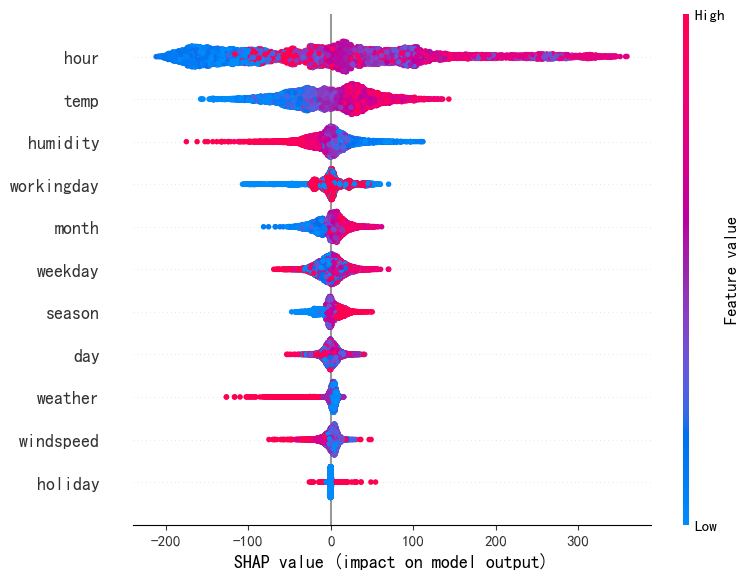

In [25]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 数据预处理
data = pd.read_csv("./data/data.csv")
data = data.drop(['atemp'], axis=1)

# 日期特征工程
format = '%Y-%m-%d %H:%M'
data['date'] = pd.to_datetime(data['datetime'], format=format)
for time_unit in ['month', 'day', 'weekday', 'hour']:
    data[time_unit] = getattr(data.date.dt, time_unit)
data = data.drop(['date', 'datetime'], axis=1)

# 数据集划分
X = data.drop(['count'], axis=1)
y = data['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 异常值处理
Q1, Q3 = X_train['humidity'].quantile([0.25, 0.75])
IQR = Q3 - Q1
mask = X_train['humidity'].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
X_train, y_train = X_train[mask], y_train[mask]

# 模型训练
xgb_model = XGBRegressor(
    learning_rate=0.1,  # 修正拼写错误
    n_estimators=200,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# SHAP解释
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_train, check_additivity=False)
shap.summary_plot(shap_values, X_train)


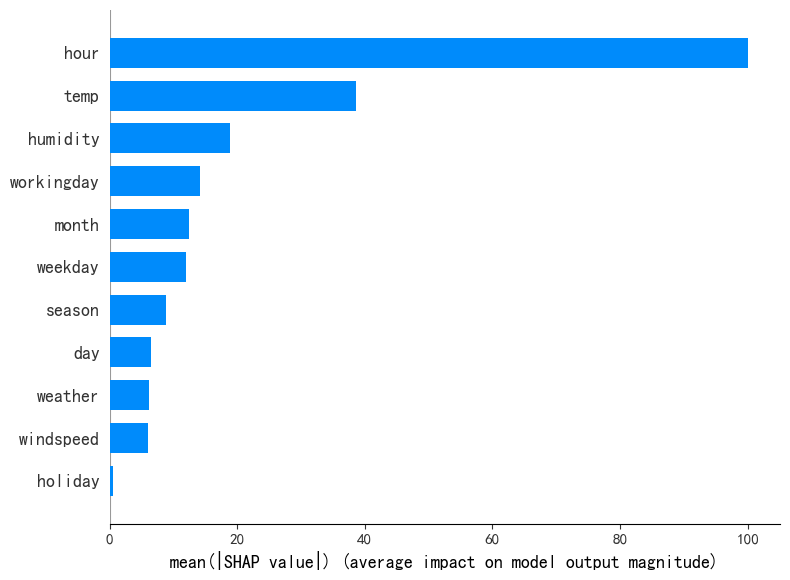

In [26]:
##SHAP汇总图设置为条形图，可以显示特征重要性
##这是回归问题不是每个类别都有这个类别对应的shap值
shap.summary_plot(shap_values, X_train, plot_type="bar")

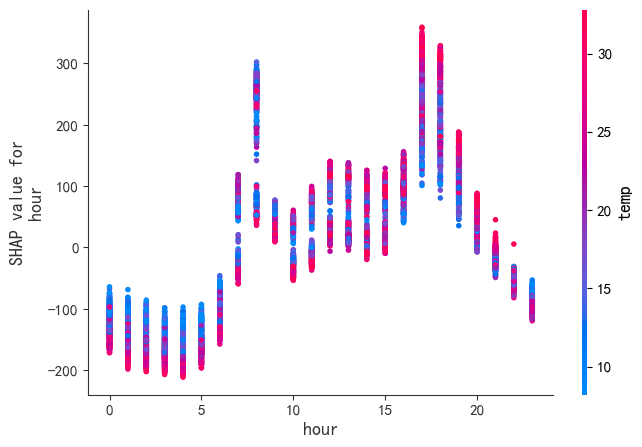

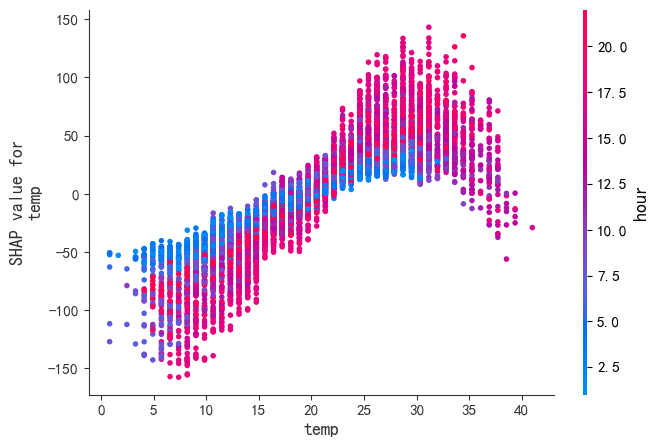

In [27]:
##同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('hour', shap_values, X_train, interaction_index="temp")
##同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('temp', shap_values, X_train, interaction_index="hour")

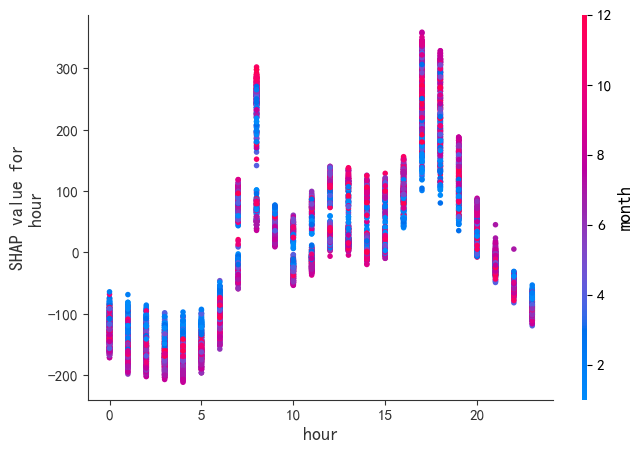

In [28]:
##同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('hour', shap_values, X_train, interaction_index="month")

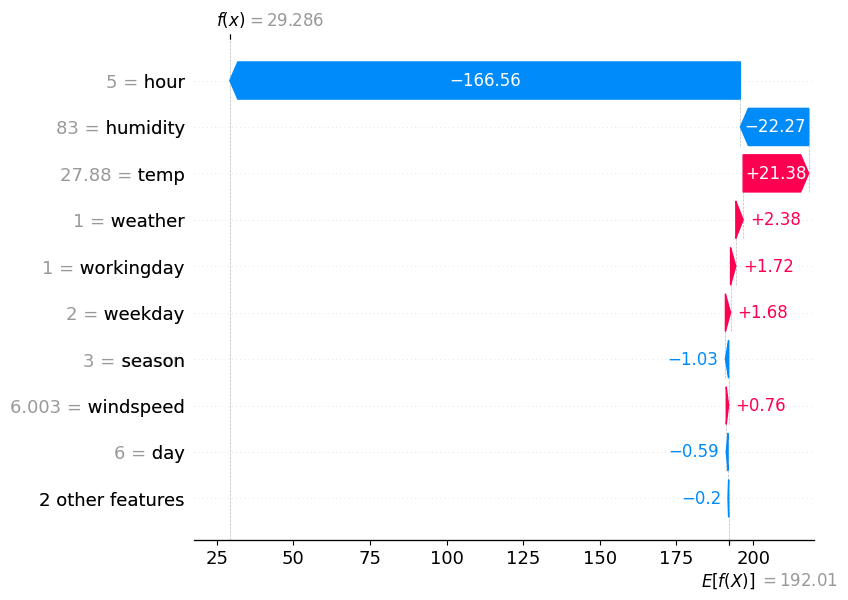

In [29]:
import shap
import matplotlib.pyplot as plt

single_shap_values = shap_values[0]##获取第一个样本的SHAP值

single_features = X_train.iloc[0] if hasattr(X_train, 'iloc') else X_train[0]##获取第一个样本的特征值

single_explanation = shap.Explanation(values=single_shap_values, ##创建Explanation对象
                                      base_values=explainer.expected_value, 
                                      data=single_features)

##设置字体，默认的字体不显示负号
plt.rcParams['font.family'] = 'DejaVu Sans'##可以尝试其他字体如Arial等

shap.plots.waterfall(single_explanation)##可视化第一个样本的SHAP值
plt.show()

pdpbox可解释性分析

0.2.1


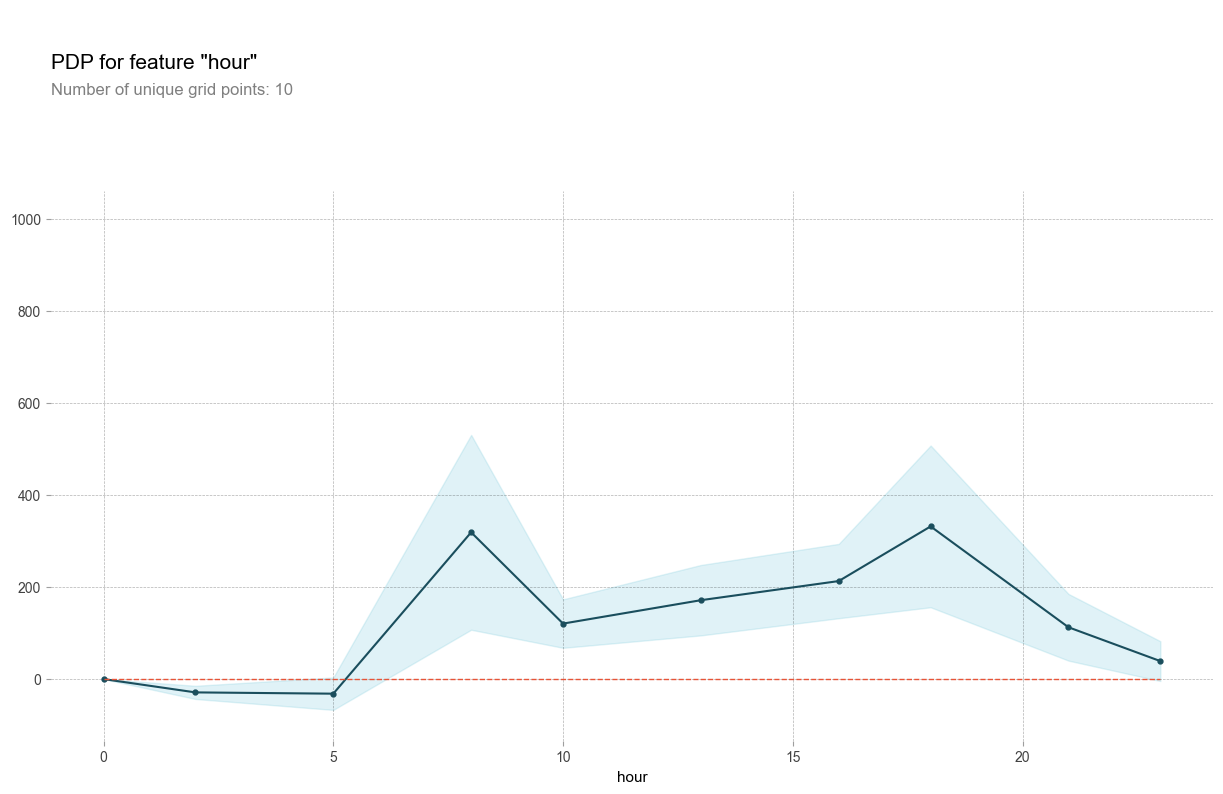

In [30]:
import pdpbox
print(pdpbox.__version__)

from pdpbox import pdp

feature_name = 'hour'  # 分析的特征名称

# 使用 pdp_isolate 函数替代 PDPIsolate 类
pdp_isolate = pdp.pdp_isolate(
    model=xgb_model,       # 传入模型
    dataset=X_train,       # 确保参数名为 dataset
    model_features=X_train.columns.tolist(),  # 特征列表
    feature=feature_name   # 目标特征
)

# 使用 pdp_plot 绘制结果
fig, axes = pdp.pdp_plot(pdp_isolate, feature_name)
plt.show()




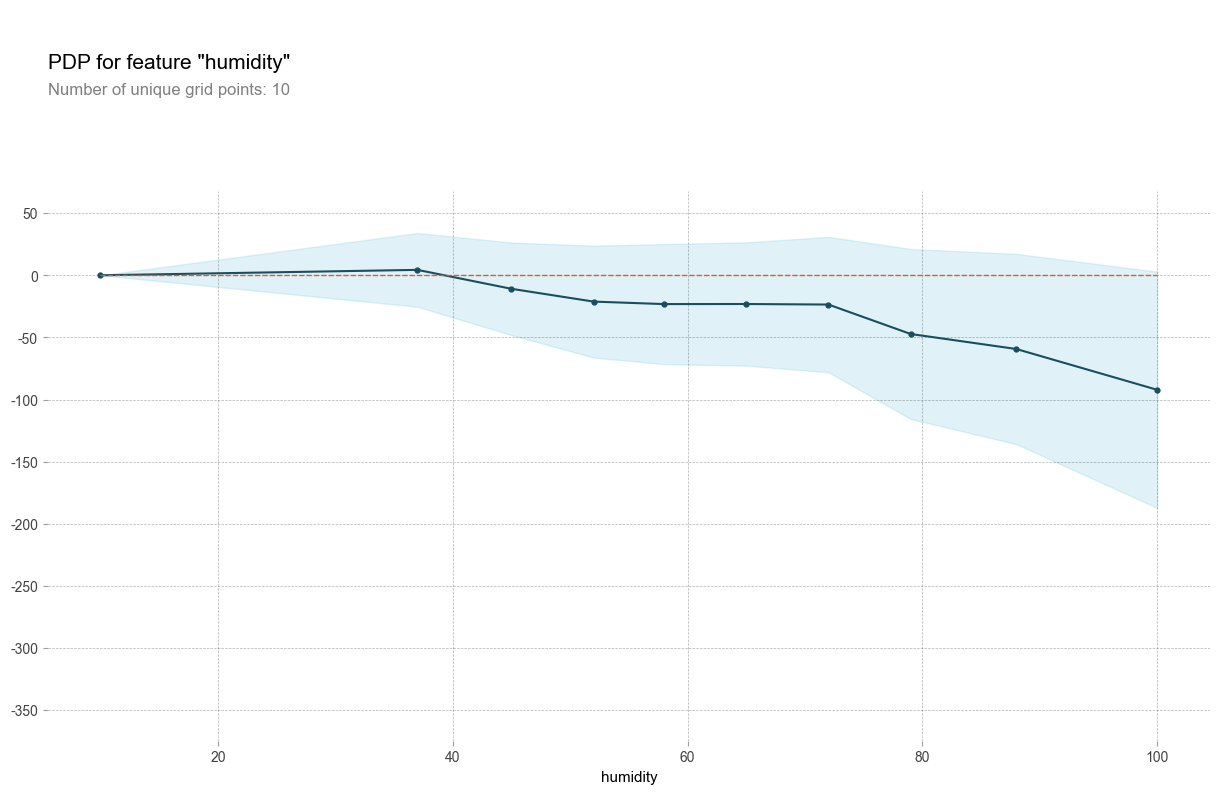

In [31]:
from pdpbox import pdp, info_plots

feature_name = 'humidity'##选择要分析的特征名称，替换 'feature_name' 为实际特征名

pdp_feature = pdp.pdp_isolate(##计算部分依赖值
    model=xgb_model,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature_name
)

fig, axes = pdp.pdp_plot(pdp_feature, feature_name)##绘制部分依赖图

import matplotlib.pyplot as plt##显示图形
plt.show()

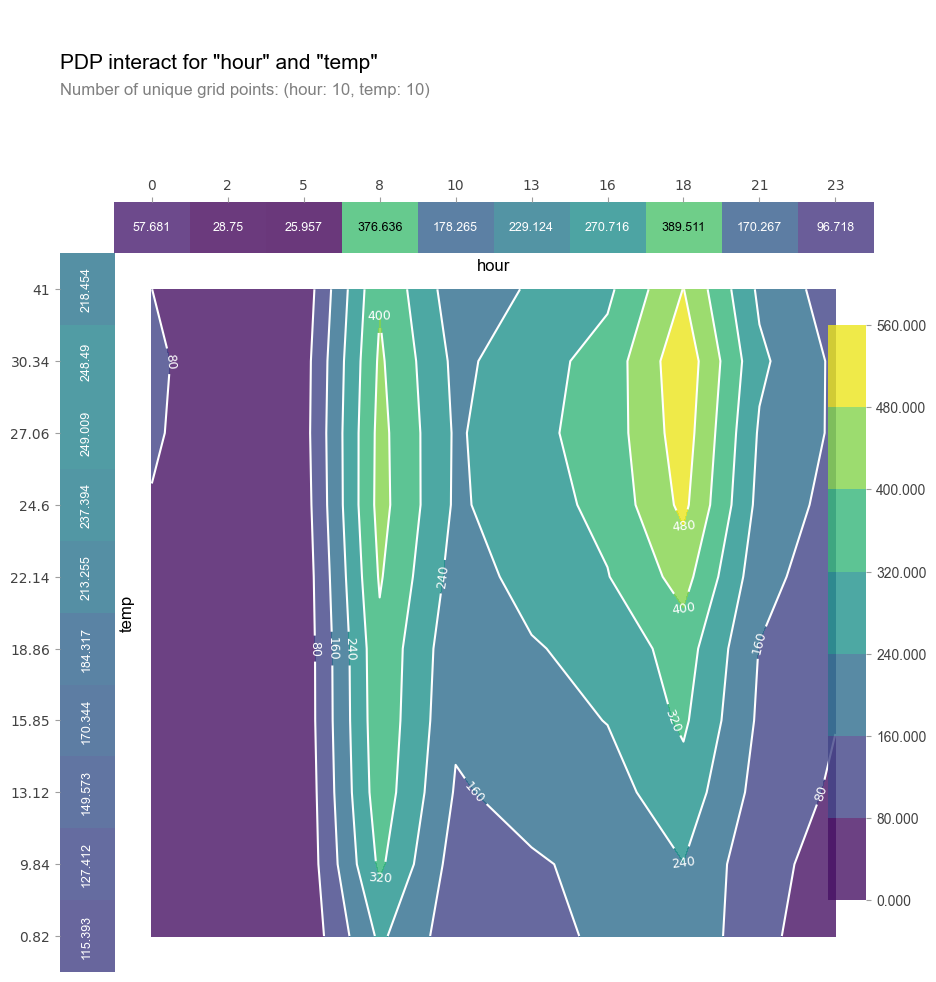

In [32]:
from pdpbox import pdp, info_plots##绘制交互效应图
import matplotlib.pyplot as plt
feature1_name = 'hour'##选择要分析的两个特征名称，替换为实际特征名
feature2_name = 'temp'

pdp_interact_out = pdp.pdp_interact(##计算两个特征的部分依赖交互值
    model=xgb_model,
    dataset=X_train,
    model_features=X_train.columns,
    features=[feature1_name, feature2_name]
)

fig, axes = pdp.pdp_interact_plot(##绘制二维部分依赖图
    pdp_interact_out=pdp_interact_out,
    feature_names=[feature1_name, feature2_name],
    plot_type='contour',##也可以使用'grid'
    x_quantile=True,
    plot_pdp=True
)

plt.show()##显示图形